In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced


### Build dataset and trim features

In [2]:
# all of our usable dataframes
df = pd.read_csv('data/master_df.csv')

In [3]:
# read category data for name and parent name
df_category = pd.read_csv('data/category.csv')
df_category = df_category[['name', 'parent_name']]

In [4]:
# drop columns deemed unessecary
model_data = df.drop(columns = ['usd_pledged', 'current_currency','static_usd_rate','usd_exchange_rate','usd_type','id','name', 'slug', 'category', 'creator', 'location', 'photo', 'profile', 'urls', 'country_displayable_name', 'currency_symbol', 'currency_trailing_code', 'disable_communication', 'source_url', 'currency', 'pledged', 'blurb'])

# create goal_usd column so that all goal amounts are in the same units, drop fx_rate and goals afterward
model_data['goal_usd'] = model_data['fx_rate']*model_data['goal']
model_data = model_data.drop(columns=['fx_rate', 'goal'])

# combine category data and all other date
model_data = pd.concat([model_data, df_category], axis=1, join='inner')

# create percentage funded column as another metric
# model_data['percentage_funded'] = model_data.converted_pledged_amount/model_data.goal_usd*100

# create total days active column as another metric
model_data['total_days_active'] = (model_data.deadline-model_data.created_at)*0.00001157

model_data

,backers_count,converted_pledged_amount,country,created_at,deadline,is_starrable,launched_at,spotlight,staff_pick,state,state_changed_at,goal_usd,name,parent_name,total_days_active
0,18,5034,US,1609376406,1611968831,False,1609545583,True,False,successful,1611968831,5000.000000,Cookbooks,Food,29.994357
1,508,48365,HK,1606278560,1614096106,False,1608912106,True,True,successful,1614096106,44624.926500,Cookbooks,Food,90.449007
2,14,98,ES,1606477096,1607900340,False,1606751262,True,False,successful,1607900340,54.095050,Cookbooks,Food,16.466933
3,1486,127765,US,1604500905,1610082068,False,1606194068,True,True,successful,1610082068,65000.000000,Cookbooks,Food,64.574056
4,249,14574,GB,1605454727,1608573895,False,1605981895,True,True,successful,1608573895,13823.881138,Cookbooks,Food,36.088774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30987,4,501,US,1632678330,1634318870,False,1633022870,False,False,failed,1634318870,10000.000000,Software,Technology,18.981048
30988,1,1,CA,1632726042,1638144718,False,1632957118,False,False,failed,1638144719,39722.546000,Software,Technology,62.694081
30989,1,0,DK,1631517750,1635408514,False,1632816514,False,False,failed,1635408514,145430.220000,Software,Technology,45.016139
30990,3,70,US,1429554526,1432913659,False,1430321659,False,False,failed,1432913660,35000.000000,Plays,Theater,38.865169


In [5]:
model_data.isna().sum().sum()

1374

In [6]:
# drop rows with na values
model_data = model_data.dropna()

# drop rows that have state 'live' or 'cancelled'
model_data = model_data.drop(model_data[model_data['state'] == 'live'].index, axis=0)
model_data = model_data.drop(model_data[model_data['state'] == 'canceled'].index, axis=0)
model_data = model_data.reset_index(drop=True)
model_data.head()

,backers_count,converted_pledged_amount,country,created_at,deadline,is_starrable,launched_at,spotlight,staff_pick,state,state_changed_at,goal_usd,name,parent_name,total_days_active
0,18,5034,US,1609376406,1611968831,False,1609545583,True,False,successful,1611968831,5000.000000,Cookbooks,Food,29.994357
1,508,48365,HK,1606278560,1614096106,False,1608912106,True,True,successful,1614096106,44624.926500,Cookbooks,Food,90.449007
2,14,98,ES,1606477096,1607900340,False,1606751262,True,False,successful,1607900340,54.095050,Cookbooks,Food,16.466933
3,1486,127765,US,1604500905,1610082068,False,1606194068,True,True,successful,1610082068,65000.000000,Cookbooks,Food,64.574056
4,249,14574,GB,1605454727,1608573895,False,1605981895,True,True,successful,1608573895,13823.881138,Cookbooks,Food,36.088774


In [7]:
# split into X and y variables
X = model_data.drop(columns=['converted_pledged_amount'])
y = model_data.converted_pledged_amount.to_frame()

In [8]:
bins = [0, 1, 100, 1000, 5000, 20000, 50000, np.inf]
bin_representation = ['0-1', '1-100', '100-1000', '1000-5000', '5000-20000', '20000-50000', '50000-inf', '>inf']
y['bins'] = pd.cut(y.converted_pledged_amount, bins, right=True)
y = y['bins'].to_frame()

In [9]:
# generate 70% train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Encoding of non neumerical features

In [10]:
# init encoder for x values
encoder = LabelEncoder()

# encode boolean and string type columns
encoding_columns = (X.select_dtypes(include=['bool', 'object'])).columns
for column in encoding_columns:
    X_train[column] = encoder.fit_transform(X_train[column])
    X_test[column] = encoder.transform(X_test[column])

In [11]:
# new encoder for y variable (to make sure that we can reverse encoding)
y_encoder = LabelEncoder()
y_train['bins'] = y_encoder.fit_transform(y_train['bins'])
y_test['bins'] = y_encoder.transform(y_test['bins'])

### Scale values using standard scaler

In [12]:
# init standard scaler
scaler = MinMaxScaler()

# scale Train and testing set, columns=X.columns to keep column headers.
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train_scaled.head()

,backers_count,country,created_at,deadline,is_starrable,launched_at,spotlight,staff_pick,state,state_changed_at,goal_usd,name,parent_name,total_days_active
0,0.000027,0.291667,0.475624,0.478265,0.0,0.477075,0.0,0.0,0.0,0.478265,0.000011,0.657895,0.666667,0.012547
1,0.001300,1.000000,0.689793,0.702017,0.0,0.694142,1.0,0.0,1.0,0.702017,0.000250,0.736842,0.666667,0.023404
2,0.000022,0.875000,0.752919,0.755435,0.0,0.753354,0.0,0.0,0.0,0.755435,0.000005,0.026316,0.555556,0.010232
3,0.001365,1.000000,0.709303,0.712218,0.0,0.710616,1.0,0.0,1.0,0.712218,0.000200,0.210526,0.444444,0.011092
4,0.000005,0.875000,0.602231,0.602278,0.0,0.602745,0.0,0.0,0.0,0.602278,0.000008,0.157895,0.000000,0.008176


### Resampling for under represented bins 

In [13]:
ros = RandomOverSampler(random_state=1)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

In [14]:
y_train_resampled.bins.unique()

array([2, 5, 1, 4, 7, 3, 6, 0])

### Build classifier

In [15]:
# init and fit RF classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_resampled, y_train_resampled)

/Users/stuartperry/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier()

In [16]:
# perform predictions on testing data
predictions  = rf_classifier.predict(X_test_scaled)

In [17]:
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73       282
           1       0.71      0.86      0.78       951
           2       0.78      0.78      0.78      1507
           3       0.87      0.86      0.86      2347
           4       0.88      0.84      0.86      1855
           5       0.77      0.73      0.75       591
           6       0.86      0.83      0.84       395
           7       0.99      0.92      0.96       450

    accuracy                           0.83      8378
   macro avg       0.83      0.81      0.82      8378
weighted avg       0.83      0.83      0.83      8378



In [18]:
y_test

,bins
26262,2
20121,4
11166,4
3834,7
13723,1
...,...
14402,2
27839,4
27597,7
1613,2


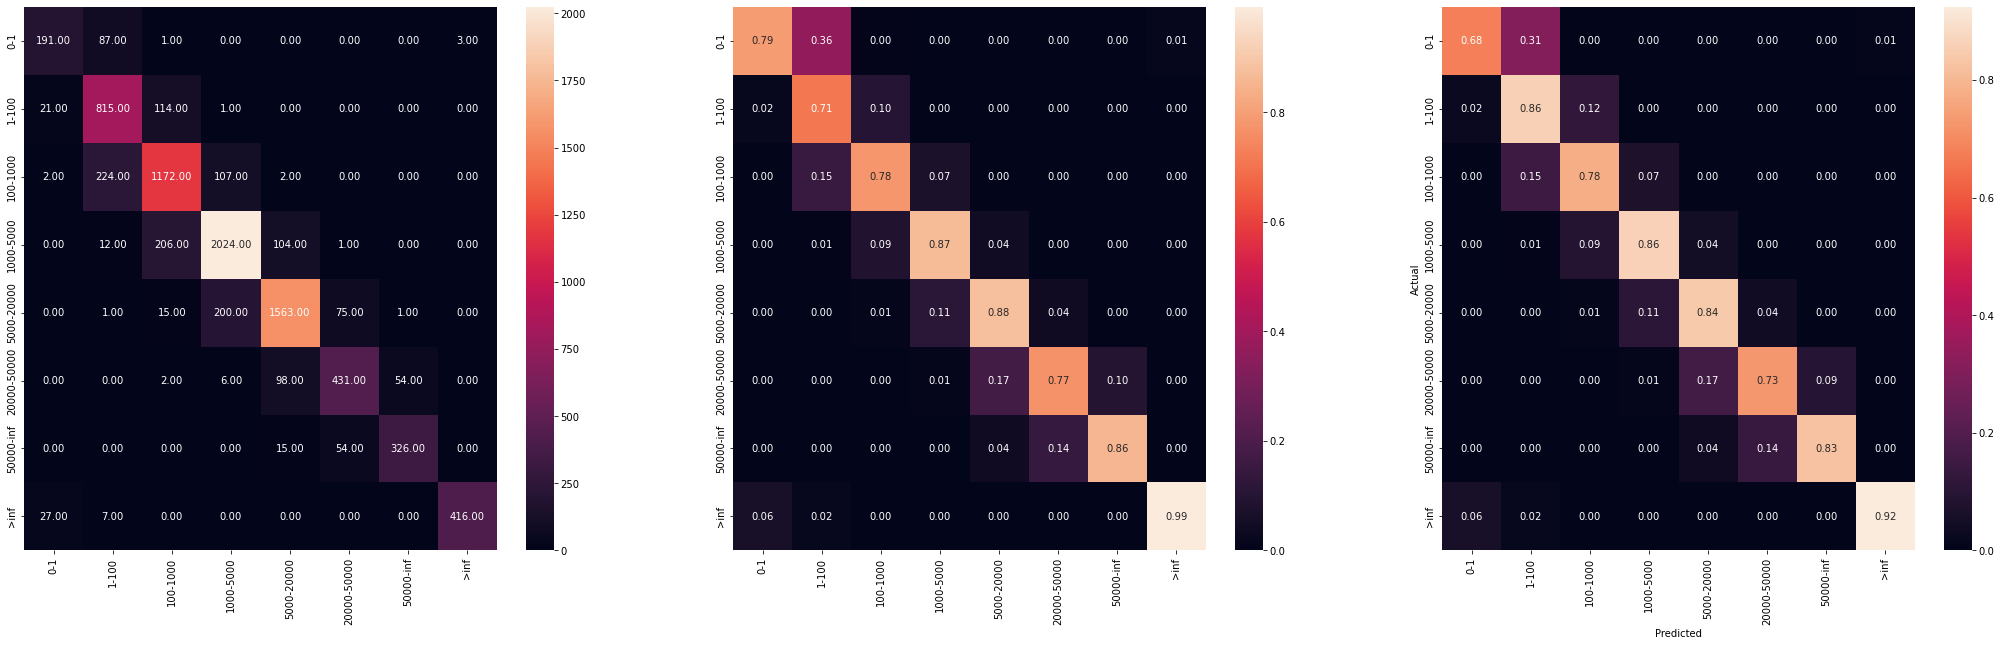

In [19]:

cm = confusion_matrix(y_true=y_test, y_pred=predictions)
cm_recall = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_precision = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(36,10))
heatmap(cm, annot=True, fmt='.2f', xticklabels=bin_representation, yticklabels=bin_representation, ax = ax1)
heatmap(cm_precision, annot=True, fmt='.2f', xticklabels=bin_representation, yticklabels=bin_representation, ax=ax2)
heatmap(cm_recall, annot=True, fmt='.2f', xticklabels=bin_representation, yticklabels=bin_representation, ax = ax3)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)